In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# make deterministic
from mingpt.utils import set_seed
set_seed(42)

In [3]:
import os
import time
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import argparse
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from data.othello import Othello, OthelloBoardState
from mingpt.dataset import CharDataset
from mingpt.model import GPT, GPTConfig, GPTforProbing
from mingpt.probe_trainer import Trainer, TrainerConfig
from mingpt.probe_model import BatteryProbeClassification, BatteryProbeClassificationTwoLayer

### Training playertype probes

In [4]:
model_ckpt = "playertype/playertype_e40"
probe_root = "playertype"
probe_type = "player" # player or state
probe_layer = 6
twolayer = False
epo = 16
mid_dim = 256

In [5]:
folder_name = f"{probe_root}/probes/{probe_type}"

if twolayer:
    folder_name = folder_name + f"_tl{mid_dim}"  # tl for probes without batchnorm

print(f"Running experiment for {folder_name}")
othello = Othello(data_root="othello_1player", n_games=10000, deduplicate=False, test_split=0)

player_types, games = zip(*othello)
train_dataset = CharDataset(games)


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment for playertype/probes/player


Mem Used: 1.136 GB:   0%|          | 0/50 [00:00<?, ?it/s]

Loaded 100000 from 1 files
Using 10000 for training, 0 for validation
Dataset created has 10000 sequences, 61 unique words.


In [6]:
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size, n_layer=8, n_head=8, n_embd=512)
model = GPTforProbing(mconf, probe_layer=probe_layer)
# if args.random:
#     model.apply(model._init_weights)
if model_ckpt:  # trained on synthetic dataset
    load_res = model.load_state_dict(torch.load(f"./ckpts/{model_ckpt}.ckpt"))
else:
    raise Exception("not given ckpt path or random flag")

if torch.cuda.is_available():
    device = torch.cuda.current_device()
    model = model.to(device)

In [7]:
# creating dataset of activations and properties
loader = DataLoader(train_dataset, shuffle=False, pin_memory=True, batch_size=1, num_workers=1)
act_container = []
property_container = []
time_container = []

for i, (x, y) in tqdm(enumerate(loader), total=len(loader)):
    tbf = [train_dataset.itos[_] for _ in x.tolist()[0]]
    # truncates game if it is less than 60 moves
    valid_until = tbf.index(-100) if -100 in tbf else 999
    # gets activations for each move
    a = OthelloBoardState()
    act = model(x.to(device))[0, ...].detach().cpu()  # [block_size, f]
    act_container.extend([_[0] for _ in act.split(1, dim=0)[:valid_until]])

    if probe_type == "state":
        properties = a.get_gt(tbf[:valid_until], "get_state")  # [block_size, ]
    elif probe_type == "player":
        properties = [[player_types[i]] for _ in range(len(tbf[:valid_until]))]
    property_container.extend(properties)

    time_container.extend([i for i in range(len(tbf[:valid_until]))])

    assert len(act_container) == len(property_container)
    assert len(act_container) == len(time_container)


100%|██████████| 10000/10000 [00:56<00:00, 177.95it/s]


In [8]:
# 3 for board state (empty/black/white), 4 for player type (corners)
probe_class = 4 
# 64 for board state, 1 for player type
num_task = 1 

if twolayer:
    probe = BatteryProbeClassificationTwoLayer(device, probe_class=probe_class, num_task=num_task, mid_dim=mid_dim)
else:
    probe = BatteryProbeClassification(device, probe_class=probe_class, num_task=num_task)

In [10]:
class ProbingDataset(Dataset):
    def __init__(self, act, y, time):
        assert len(act) == len(y)
        print(f"{len(act)} pairs loaded...")
        self.act = act
        self.y = y
        self.time = time
        # print(np.sum(np.array(y)==0), np.sum(np.array(y)==1), np.sum(np.array(y)==2))
        print("y:", np.unique(y, return_counts=True))
        print("time:", np.unique(time, return_counts=True))
        
    def __len__(self, ):
        return len(self.y)
    def __getitem__(self, idx):
        return self.act[idx], torch.tensor(self.y[idx]).to(torch.long), self.time[idx]

probing_dataset = ProbingDataset(act_container, property_container, time_container)
train_size = int(0.8 * len(probing_dataset))
test_size = len(probing_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(probing_dataset, [train_size, test_size])

585823 pairs loaded...
y: (array([0, 1, 2, 3]), array([150654, 143013, 146761, 145395]))
time: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58]), array([10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
       10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
       10000, 10000, 10000, 10000, 10000,  9997,  9996,  9995,  9993,
        9992,  9988,  9986,  9984,  9982,  9980,  9978,  9972,  9961,
        9950,  9944,  9939,  9929,  9917,  9902,  9897,  9886,  9876,
        9865,  9852,  9843,  9832,  9822,  9803,  9785,  9771,  9752,
        9738,  9720,  9703,  9671,  9622]))


In [79]:
max_epochs = epo
t_start = time.strftime("_%Y%m%d_%H%M%S")
tconf = TrainerConfig(
    max_epochs=max_epochs, 
    batch_size=1024, 
    learning_rate=1e-3,
    betas=(.9, .999), 
    lr_decay=True, 
    warmup_tokens=len(train_dataset)*5, 
    final_tokens=len(train_dataset)*max_epochs,
    num_workers=0, 
    weight_decay=0., 
    ckpt_path=os.path.join("./ckpts/", folder_name, f"layer{probe_layer}")
)
trainer = Trainer(probe, train_dataset, test_dataset, tconf)

In [80]:
trainer.train(prt=True)
trainer.save_traces()
trainer.save_checkpoint()

epoch 1: train loss 1.57106; lr 1.00e-03; train acc 53.32%:   1%|▏         | 6/458 [00:00<00:08, 54.33it/s]

Decayed: {'proj.weight', 'proj.bias'}


epoch 1: train loss 1.49397; lr 1.00e-03; train acc 59.38%:   1%|▏         | 6/458 [00:00<00:08, 54.33it/s]

epoch 1: train loss 0.11802; lr 1.00e-03; train acc 98.12%: 100%|██████████| 458/458 [00:06<00:00, 75.38it/s]
epoch 2: train loss 0.07059; lr 1.00e-03; train acc 97.83%: 100%|██████████| 458/458 [00:05<00:00, 85.56it/s]
epoch 3: train loss 0.06960; lr 1.00e-03; train acc 98.12%: 100%|██████████| 458/458 [00:05<00:00, 85.19it/s]
epoch 4: train loss 0.06870; lr 1.00e-03; train acc 98.26%: 100%|██████████| 458/458 [00:06<00:00, 75.90it/s]
epoch 5: train loss 0.06871; lr 1.00e-03; train acc 97.97%: 100%|██████████| 458/458 [00:05<00:00, 89.13it/s]
epoch 6: train loss 0.06641; lr 7.50e-04; train acc 97.97%: 100%|██████████| 458/458 [00:05<00:00, 87.27it/s]
epoch 7: train loss 0.06606; lr 7.50e-04; train acc 98.41%: 100%|██████████| 458/458 [00:05<00:00, 77.89it/s]
epoch 8: train loss 0.06506; lr 5.63e-04; train acc 97.83%: 100%|██████████| 458/458 [00:05<00:00, 86.92it/s]
epoch 9: train loss 0.06352; lr 4.22e-04; train acc 98.26%: 100%|██████████| 458/458 [00:05<00:00, 87.98it/s]
epoch 10: 

### testing probe accuracy

In [11]:
probe = BatteryProbeClassification(device, probe_class=4, num_task=1)
load_res = probe.load_state_dict(torch.load(f"./ckpts/playertype/probes/player/layer6/checkpoint.ckpt"))

probe = probe.to(device)

In [25]:
train_loader = DataLoader(train_dataset, shuffle=False, pin_memory=True, batch_size=128, num_workers=1)

total_states = 0
total_correct = 0

correct_over_time = np.zeros(59)
total_over_time = np.zeros(59)

pbar = tqdm(enumerate(train_loader), total=len(train_loader))
for it, (x, y, time) in pbar:
    x = x.to(device)  # [B, f]
    y = y.to(device)  # [B, #task=1] 

    logits, loss = probe(x, y)
    pred = torch.argmax(logits, dim=2)
    pred = pred.detach().cpu().numpy()

    true = y.detach().cpu().numpy()
    correct = pred == true
    total_correct += np.count_nonzero(correct)

    total_states += x.shape[0]

    time = time.detach().cpu().numpy()
    # correct_over_time[time] += correct.flatten()

    for (t, c) in zip(time, correct.flatten()):
        total_over_time[t] += 1
        if c:
            correct_over_time[t] += 1

    # print(sorted(time))

print(correct_over_time)

    

100%|██████████| 3662/3662 [00:10<00:00, 333.66it/s]

[3549. 6600. 6933. 7475. 7602. 7702. 7717. 7778. 7820. 7921. 7950. 7876.
 7878. 7916. 7893. 7962. 8000. 7920. 7953. 7967. 7986. 7939. 7954. 7925.
 7961. 7851. 7949. 7924. 7978. 7954. 7990. 7989. 8006. 7980. 8032. 7981.
 7896. 7958. 7920. 7944. 7919. 7929. 7940. 7913. 7934. 7922. 7797. 7897.
 7937. 7862. 7830. 7809. 7779. 7814. 7754. 7771. 7748. 7680. 7702.]


In [26]:
print(total_correct, total_states)
print(total_correct / total_states)

458466 468658
0.9782527984159024


In [28]:
avg = correct_over_time / total_over_time
print(avg)

[0.44445836 0.8247938  0.86770964 0.92799503 0.94918217 0.9557017
 0.96837746 0.97725845 0.98290598 0.9864259  0.98819142 0.9896959
 0.98982284 0.99222863 0.99096045 0.99289188 0.9934186  0.99310345
 0.99375234 0.99376325 0.99464441 0.99399023 0.99512073 0.99597838
 0.99624578 0.99556176 0.99599048 0.9966042  0.99687617 0.99724173
 0.99688085 0.99737828 0.99775673 0.99824869 0.9985082  0.99874859
 0.99848255 0.99861965 0.99873897 0.99899396 0.99861286 0.99886621
 0.99811439 0.99924233 0.9991185  0.99899117 0.99859119 0.99886162
 0.99899308 0.99936443 0.9992343  0.99936012 0.99935766 0.99936053
 0.99987105 0.99910003 0.99909736 0.99895942 0.99857384]


Text(0, 0.5, 'Accuracy')

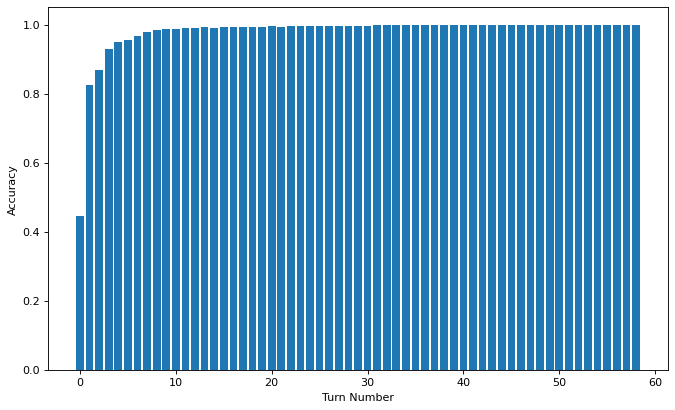

In [45]:
fig = plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(range(len(avg)), avg)
plt.xlabel("Turn Number")
plt.ylabel("Accuracy")

### intervening on player type

In [4]:
from data.othello import permit, permit_reverse
from mingpt.model import GPTforProbeIA
import seaborn as sns

In [5]:
def draw_board_heatmap(board, **kwargs):
    fig = plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
    sns.heatmap(board.reshape(8, 8), **kwargs,
            yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True, 
            annot=True, fmt=".2f")
    return fig

In [6]:
def draw_heatmap_from_tokens(token_pred, **kwargs):
    # take off first token, as it isn't a board position
    token_pred = token_pred[1:]
    # add padding to get from tokens -> board positions
    padding = np.zeros(2)
    board = np.concatenate([token_pred[:27], padding, token_pred[27:33], padding, token_pred[33:]], axis=0)
    # plotting
    return draw_board_heatmap(board, **kwargs)

In [7]:
def load_probes(ckpt_path, layer_range):
    probes = {}
    for layer in layer_range:
        p = BatteryProbeClassification(torch.cuda.current_device(), probe_class=4, num_task=1)
        load_res = p.load_state_dict(torch.load(f"./ckpts/{ckpt_path}/layer{layer}/checkpoint.ckpt"))
        p.eval()
        probes[layer] = p
    return probes

In [8]:
def load_model_layers(ckpt_path, layer_range):
    mconf = GPTConfig(61, 59, n_layer=8, n_head=8, n_embd=512)

    models = {}
    for layer in layer_range:
        model = GPTforProbeIA(mconf, probe_layer=layer)
        # model = GPT(mconf)
        load_res = model.load_state_dict(torch.load(f"./ckpts/{ckpt_path}.ckpt"))
        if torch.cuda.is_available():
            device = torch.cuda.current_device()
            model = model.to(device)
        _ = model.eval()
        models[layer] = model

    return models, device

In [9]:
layer_range = range(4, 9)
models, device = load_model_layers("playertype/playertype_e40", layer_range)
probes = load_probes("playertype/probes/player", layer_range)

In [10]:
othello = Othello(data_root="othello_1player", n_games=100, test_split=0, deduplicate=False)
# train_dataset = CharDataset(othello)
player_types, games = zip(*othello)
train_dataset = CharDataset(games)

Mem Used: 3.626 GB:   0%|          | 0/50 [00:00<?, ?it/s]

Loaded 100000 from 1 files
Using 100 for training, 0 for validation
Dataset created has 100 sequences, 61 unique words.


In [11]:
game_index = 9
completion = games[game_index][:10]
print("player type:", player_types[game_index])
# completion = othello[2][:20]
# completion = [permit(x) for x in ['c4', 'e3', 'f2', 'e2', 'd2']]

ob = OthelloBoardState()
ob.update(completion)
ob.__print__()
print([permit_reverse(x) for x in ob.get_valid_moves()])

player type: 2
--------------------
['f5', 'f4', 'g3', 'g6', 'g5', 'g4', 'h3', 'h2', 'h1', 'h4']
a                
b                
c                
d       O X      
e       O X      
f       O X      
g     O O O O    
h X X X O        
  1 2 3 4 5 6 7 8
--------------------
['c3', 'd3', 'e3', 'f3', 'h5', 'h7']


In [149]:
# setting up partial game
ab = OthelloBoardState()
ab.update(completion)

partial_game = torch.tensor([train_dataset.stoi[s] for s in completion], dtype=torch.long).to(device)

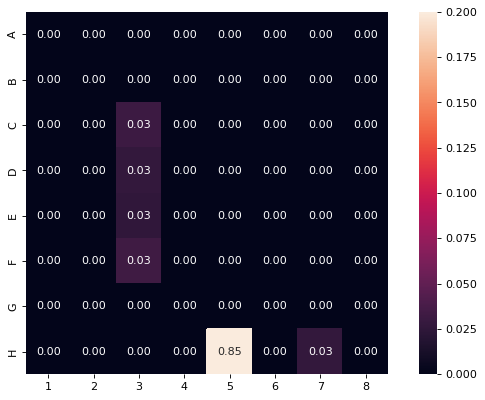

In [150]:
pre_intv_pred, _ = models[layer_range.stop-1](partial_game[None, :])  # [B, T, F=512]
pre_intv_pred = pre_intv_pred[0, -1, :]
pre_intv_pred = torch.softmax(pre_intv_pred, dim=0).detach().cpu().numpy()

fig = draw_heatmap_from_tokens(pre_intv_pred, vmax=0.2)

In [154]:
# settings for intervention optimization
htd = {"lr": 1e-3, "steps": 1000, "reg_strg": 0.2}

player_type_target = 0

In [155]:
for i, layer in enumerate(layer_range):
    p = probes[layer]

    # at starting layer, we set up the intervention by doing a forward pass up to the starting layer
    if i == 0:
        print("setting up intervention starting at layer", layer)
        whole_mid_act = models[layer_range.start].forward_1st_stage(partial_game[None, :])  # [B, T, F=512]

        mid_act = whole_mid_act[0, -1]
        pre_intv_logits = p(mid_act[None, :])[0].squeeze(0)  # [1, 4]
        labels_pre_intv = pre_intv_logits.detach().argmax(dim=-1)
        print("pre-intv label:", labels_pre_intv.item())
        print(pre_intv_logits)

    # after starting layer, use forward_2nd_stage to get to next layer
    else:
        print("LAYER", layer)
        whole_mid_act = models[layer_range.start].forward_2nd_stage(whole_mid_act, layer-1, layer)[0]  # [1, T, F=512]

    # cut out most recent features and check probe prediction
    mid_act = whole_mid_act[0, -1]
    pre_intv_logits = p(mid_act[None, :])[0].squeeze(0)  # [1, 4]

    labels_pre_intv = pre_intv_logits.detach().argmax(dim=-1)

    # setting our desired player type
    desired_labels = labels_pre_intv.clone()
    desired_labels[0] = player_type_target
    print("desired label:", desired_labels.item())

    # make actual intervention on mid activations
    new_mid_act = mid_act.clone()

    # linear intervention
    # steering_vector = torch.rand_like(new_mid_act)
    steering_vector = p.proj.weight.data[player_type_target]
    new_mid_act += steering_vector * 4
    new_mid_act -= p.proj.weight.data[2] * 4
    
    # gradient descent intervention
    # new_mid_act = torch.tensor(mid_act.detach().cpu().numpy()).cuda()
    # new_mid_act.requires_grad = True
    # opt = torch.optim.Adam([new_mid_act], lr=htd["lr"])

    # for i in range(htd["steps"]): 
    #     opt.zero_grad()
    #     logits_running = p(new_mid_act[None, :])[0][0]  # [1, 4]

    #     loss = F.cross_entropy(logits_running, desired_labels, reduction="none")
    #     loss.backward()  # by torch semantics, loss is to be minimized
    #     opt.step()

    post_intv_logits = p(new_mid_act[None, :])[0].squeeze(0) # [1, 4]
    print(post_intv_logits)

    # swap in 
    whole_mid_act[0, -1] = new_mid_act

tb_resumed = whole_mid_act
post_intv_pred, _ = models[layer_range.start].predict(tb_resumed)
post_intv_pred = post_intv_pred[0, -1, :]
post_intv_pred = torch.softmax(post_intv_pred, dim=0).detach().cpu().numpy()
    

setting up intervention starting at layer 4
pre-intv label: 2
tensor([[ 0.1345, -5.7353,  6.3547, -2.7187]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
desired label: 0
tensor([[ 55.2399,  44.3132, -48.1005, -54.0409]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
LAYER 5
desired label: 0
tensor([[ 73.8264,  61.6009, -63.6407, -70.6507]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
LAYER 6
desired label: 0
tensor([[ 60.9965,  49.8065, -55.9303, -61.5624]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
LAYER 7
desired label: 0
tensor([[ 46.5982,  37.3356, -35.4597, -43.9868]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
LAYER 8
desired label: 0
tensor([[ 32.3542,  24.7379, -24.0951, -30.1745]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)


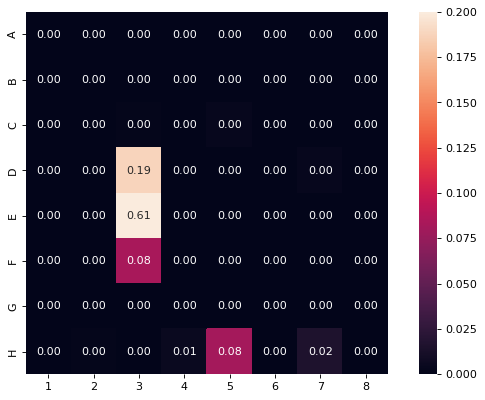

In [156]:
fig = draw_heatmap_from_tokens(post_intv_pred, vmax=0.2)

### testing many interventions

In [12]:
player_type_sorts = {
    # type 0: top left bias
    0: lambda x: (x // 8, x % 8),
    # type 1: top right bias
    1: lambda x: (x // 8, -(x % 8)),
    # type 2: bottom left bias
    2: lambda x: (-(x // 8), x % 8),
    # type 3: bottom right bias
    3: lambda x: (-(x // 8), -(x % 8)),
}

In [13]:
def linear_playertype_intervention(models, device, probes, completion, player_type_target, scale=1):
    layer_range = range(4, 9)

    # setting up partial game
    ab = OthelloBoardState()
    ab.update(completion)

    partial_game = torch.tensor([train_dataset.stoi[s] for s in completion], dtype=torch.long).to(device)

    pre_intv_pred, _ = models[layer_range.stop-1](partial_game[None, :])  # [B, T, F=512]
    pre_intv_pred = pre_intv_pred[0, -1, :].detach().cpu().numpy()

    for i, layer in enumerate(layer_range):
        p = probes[layer]

        # at starting layer, we set up the intervention by doing a forward pass up to the starting layer
        if i == 0:
            # print("setting up intervention starting at layer", layer)
            whole_mid_act = models[layer_range.start].forward_1st_stage(partial_game[None, :])  # [B, T, F=512]

            mid_act = whole_mid_act[0, -1]
            pre_intv_logits = p(mid_act[None, :])[0].squeeze(0)  # [1, 4]
            labels_pre_intv = pre_intv_logits.detach().argmax(dim=-1)
            # print("pre-intv label:", labels_pre_intv.item())
            # print(pre_intv_logits.detach().cpu().numpy())

        # after starting layer, use forward_2nd_stage to get to next layer
        else:
            # print("LAYER", layer)
            whole_mid_act = models[layer_range.start].forward_2nd_stage(whole_mid_act, layer-1, layer)[0]  # [1, T, F=512]

        # cut out most recent features and check probe prediction
        mid_act = whole_mid_act[0, -1]
        pre_intv_logits = p(mid_act[None, :])[0].squeeze(0)  # [1, 4]

        labels_pre_intv = pre_intv_logits.detach().argmax(dim=-1)

        # setting our desired player type
        desired_labels = labels_pre_intv.clone()
        desired_labels[0] = player_type_target
        # print("desired label:", desired_labels.item())

        # make actual intervention on mid activations
        new_mid_act = mid_act.clone()

        # linear intervention
        steering_vector = p.proj.weight.data[player_type_target]
        new_mid_act += steering_vector * scale
        new_mid_act -= p.proj.weight.data[2] * scale

        # post_intv_logits = p(new_mid_act[None, :])[0].squeeze(0) # [1, 4]
        # print(post_intv_logits.detach().cpu().numpy())

        # swap in 
        whole_mid_act[0, -1] = new_mid_act

    tb_resumed = whole_mid_act
    post_intv_pred, _ = models[layer_range.start].predict(tb_resumed)
    post_intv_pred = post_intv_pred[0, -1, :].detach().cpu().numpy()
    
    return pre_intv_pred, post_intv_pred

In [14]:
def get_playertype_logits(models, device, probes, completion, layer, softmax=False):
    partial_game = torch.tensor([train_dataset.stoi[s] for s in completion], dtype=torch.long).to(device)

    p = probes[layer]

    whole_mid_act = models[layer_range.start].forward_1st_stage(partial_game[None, :])  # [B, T, F=512]
    mid_act = whole_mid_act[0, -1]
    pre_intv_logits = p(mid_act[None, :])[0].squeeze(0)  # [1, 4]

    if softmax:
        pre_intv_logits = torch.softmax(pre_intv_logits, dim=-1)

    return pre_intv_logits.detach().cpu().numpy()

In [15]:
def plot_playertype_intervention(ax, pre, post, valid_moves, prev_best=None):
    x, y = pre[1:], post[1:]

    # plotting illegal moves in grey
    ax.scatter(x, y, color='grey', zorder=1)
    # plotting legal moves as blue
    valid_tokens = [train_dataset.stoi[x] for x in valid_moves]
    ax.scatter(pre[valid_tokens], post[valid_tokens], color='blue', zorder=2)
    # highlighting prev player type move
    if prev_best is not None:
        pre_top_token = train_dataset.stoi[sorted(valid_moves, key=player_type_sorts[prev_best])[0]]
        ax.scatter(pre[pre_top_token], post[pre_top_token], color='red', zorder=5)
    # highlighting new player type move
    post_top_token = train_dataset.stoi[sorted(valid_moves, key=player_type_sorts[player_type_target])[0]]
    ax.scatter(pre[post_top_token], post[post_top_token], color='lime', zorder=5)
    # plotting x=y for context
    ax.plot([min(x), max(x)], [min(x), max(x)], color='grey', linestyle='dashed', zorder=0)

    # axis, labels
    ax.set_xlabel("Pre Intervention")
    ax.set_ylabel("Post Intervention")
    ax.axis('equal')

In [14]:
othello = Othello(data_root="othello_synthetic", n_games=100, test_split=0, deduplicate=False)
# player_types, games = zip(*othello)
# train_dataset = CharDataset(games)
train_dataset = CharDataset(othello)

  0%|          | 0/50 [00:00<?, ?it/s]

Mem Used: 3.758 GB:   0%|          | 0/50 [00:00<?, ?it/s]

Loaded 100000 from 1 files
Using 100 for training, 0 for validation
Dataset created has 100 sequences, 61 unique words.


In [15]:
completion = othello[1][:40]
# completion = games[0][:20]

ob = OthelloBoardState()
ob.update(completion)
ob.__print__()
valid_moves = ob.get_valid_moves()
print([permit_reverse(x) for x in valid_moves])

--------------------
['f5', 'f4', 'e3', 'f2', 'd3', 'd6', 'e6', 'd2', 'c6', 'g6', 'd1', 'c3', 'g5', 'f3', 'b2', 'h6', 'g3', 'f6', 'g4', 'g2', 'f7', 'c1', 'h3', 'b6', 'b7', 'h4', 'g7', 'b8', 'g1', 'e1', 'c7', 'b3', 'b4', 'h2', 'e2', 'e7', 'e8', 'a3', 'a5', 'd8']
a     O   X      
b   O O X   X O O
c O   O     X X  
d O O O X X X   O
e O X X X X X O X
f   O X O X O X  
g X O O X O X X  
h   O O O   O    
  1 2 3 4 5 6 7 8
--------------------
['a1', 'a7', 'a8', 'b1', 'c2', 'c4', 'c8', 'd7', 'f1', 'f8', 'h1', 'h5']


In [16]:
print(get_playertype_logits(models, device, probes, completion, 6, softmax=True))

[[0.40378657 0.07395019 0.28409842 0.23816486]]


--------------------
['f5', 'f4', 'e3', 'f2', 'd3', 'd6', 'e6', 'd2', 'c6', 'g6', 'd1', 'c3', 'g5', 'f3', 'b2', 'h6', 'g3', 'f6', 'g4', 'g2', 'f7', 'c1', 'h3', 'b6', 'b7', 'h4', 'g7', 'b8', 'g1', 'e1', 'c7', 'b3', 'b4', 'h2', 'e2', 'e7', 'e8', 'a3', 'a5', 'd8']
a     O   X      
b   O O X   X O O
c O   O     X X  
d O O O X X X   O
e O X X X X X O X
f   O X O X O X  
g X O O X O X X  
h   O O O   O    
  1 2 3 4 5 6 7 8
--------------------
['a1', 'a7', 'a8', 'b1', 'c2', 'c4', 'c8', 'd7', 'f1', 'f8', 'h1', 'h5']


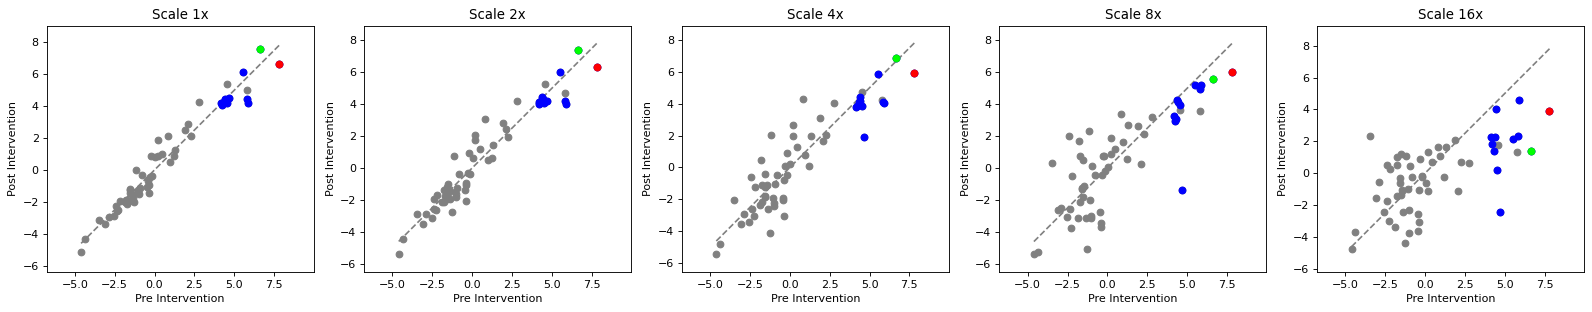

In [23]:
ob = OthelloBoardState()
ob.update(completion)
ob.__print__()
valid_moves = ob.get_valid_moves()
print([permit_reverse(x) for x in valid_moves])

fig, axs = plt.subplots(1, 5, figsize=(20, 4), dpi=80, facecolor='w', edgecolor='k')

# Loop to plot each subplot
for i, ax in enumerate(axs):
    scale = 2**i

    player_type_target = 3
    pre, post = linear_playertype_intervention(models, device, probes, completion, player_type_target, scale=scale)
    x, y = pre[1:], post[1:]

    plot_playertype_intervention(ax, pre, post, valid_moves, prev_best=2)
    ax.set_title(f"Scale {scale}x")
    
plt.tight_layout()
plt.show()

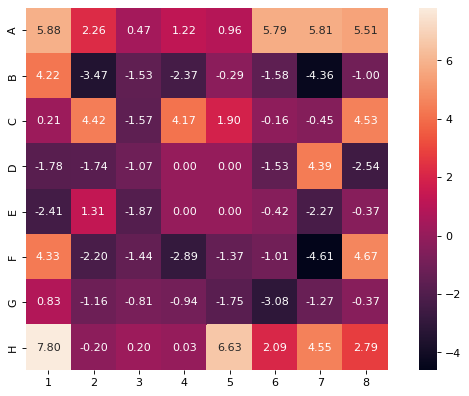

In [21]:
fig = draw_heatmap_from_tokens(pre)

### probe predictions over time

In [52]:
def probe_pred_stack_chart(probe_preds):
    fig, ax = plt.subplots(figsize=(10, 4), dpi=100, facecolor='w', edgecolor='k')

    bottom = np.zeros(len(probe_preds))
    labels = ["0: Top left", "1: Top right", "2: Bottom left", "3: Bottom right"]

    for i in range(4):
        data = [array[i] for array in probe_preds]
        ax.bar(range(len(data)), data, bottom=bottom, width=1, label=labels[i])
        bottom += data

    ax.set_title('Probe predicted player type over time')
    ax.legend(loc='lower right')
    return fig

In [25]:
# othello = Othello(data_root="othello_1player", n_games=100, test_split=0, deduplicate=False)
# player_types, games = zip(*othello)
# train_dataset = CharDataset(games)
othello = Othello(data_root="othello_synthetic", n_games=100, test_split=0, deduplicate=False)
train_dataset = CharDataset(othello)

  0%|          | 0/50 [00:00<?, ?it/s]

Mem Used: 4.353 GB:   0%|          | 0/50 [00:00<?, ?it/s]

Loaded 100000 from 1 files
Using 100 for training, 0 for validation
Dataset created has 100 sequences, 61 unique words.


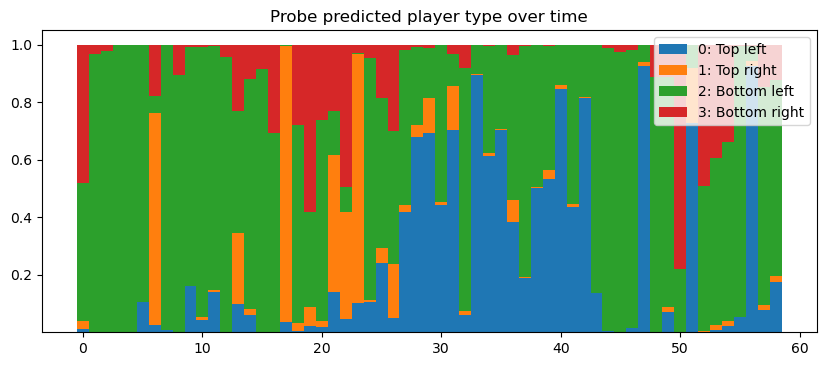

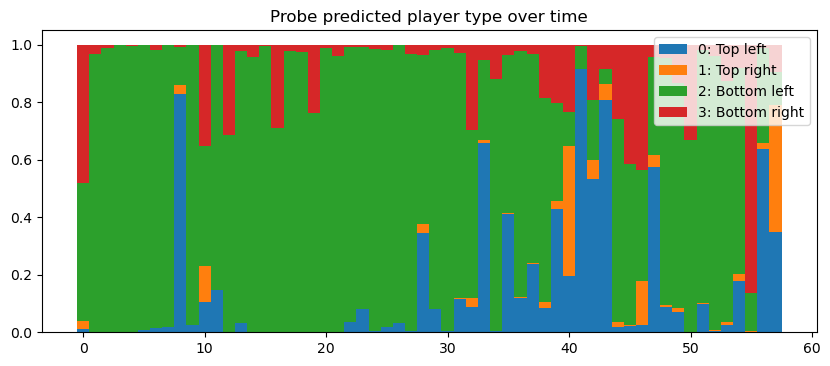

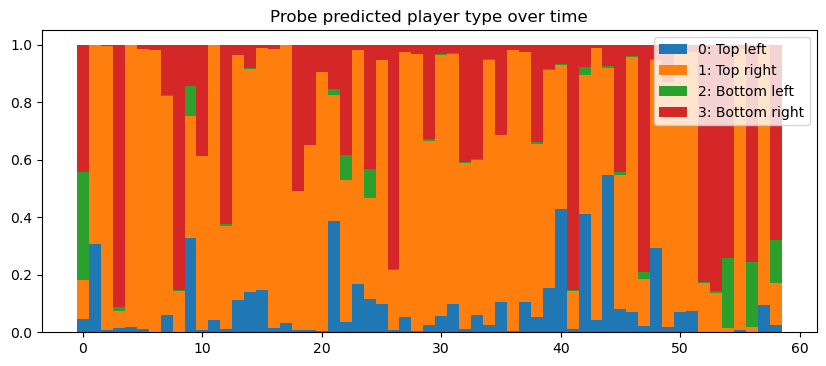

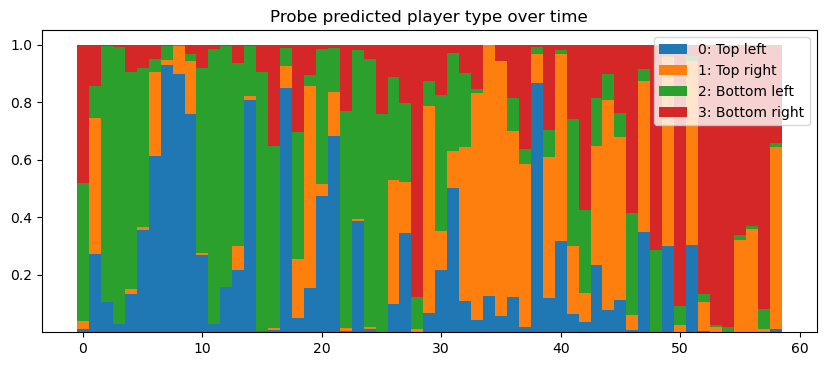

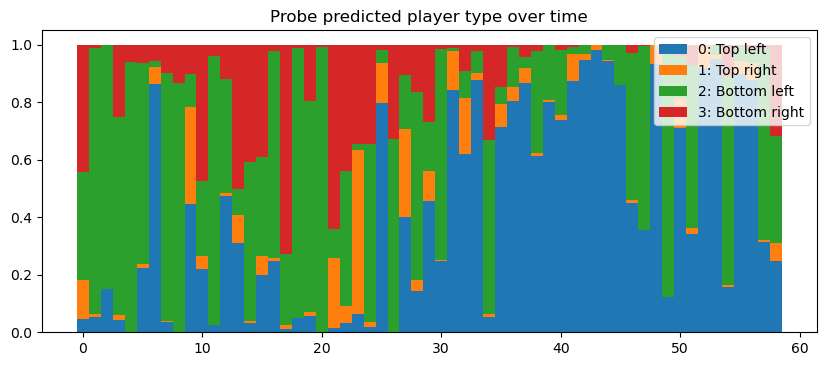

In [26]:
# othello = games
for game_index in range(5):
    game_full_len = len(othello[game_index])
    probe_preds = []
    for i in range(1, game_full_len):
        completion = othello[game_index][:i]
        logits = get_playertype_logits(models, device, probes, completion, 4, softmax=True).flatten()
        # print(logits)
        probe_preds.append(logits)

    fig = probe_pred_stack_chart(probe_preds)

### probe predictions over layers

In [18]:
full_layer_range = range(1, 9)
all_probes = load_probes("playertype/probes/player", full_layer_range)

In [53]:
# othello = Othello(data_root="othello_1player", n_games=100, test_split=0, deduplicate=False)
# player_types, games = zip(*othello)
# train_dataset = CharDataset(games)
othello = Othello(data_root="othello_synthetic", n_games=100, test_split=0, deduplicate=False)
train_dataset = CharDataset(othello)

  0%|          | 0/50 [00:00<?, ?it/s]

Mem Used: 4.504 GB:   0%|          | 0/50 [00:00<?, ?it/s]

Loaded 100000 from 1 files
Using 100 for training, 0 for validation
Dataset created has 100 sequences, 61 unique words.


In [44]:
# completion = othello[0][:40]
completion = games[0][:50]

ob = OthelloBoardState()
ob.update(completion)
ob.__print__()
valid_moves = ob.get_valid_moves()
print([permit_reverse(x) for x in valid_moves])

--------------------
['c4', 'c3', 'c2', 'b2', 'a2', 'a1', 'd3', 'a3', 'b3', 'b4', 'a4', 'a5', 'b1', 'c1', 'e6', 'b5', 'a6', 'f5', 'd2', 'a7', 'e3', 'b6', 'g4', 'c5', 'e1', 'd1', 'e2', 'f1', 'd6', 'c6', 'f2', 'f3', 'c7', 'b7', 'f6', 'f7', 'a8', 'd7', 'd8', 'c8', 'g3', 'f4', 'b8', 'g2', 'e7', 'e8', 'f8', 'g1', 'g5', 'g6']
a O O O O O O O O
b O O O O O O O O
c O O O O O O O O
d O O O O O O O O
e O X O X O X O O
f O O X O X X X O
g O O O O O X    
h                
  1 2 3 4 5 6 7 8
--------------------
['g7', 'g8', 'h5', 'h6', 'h7']


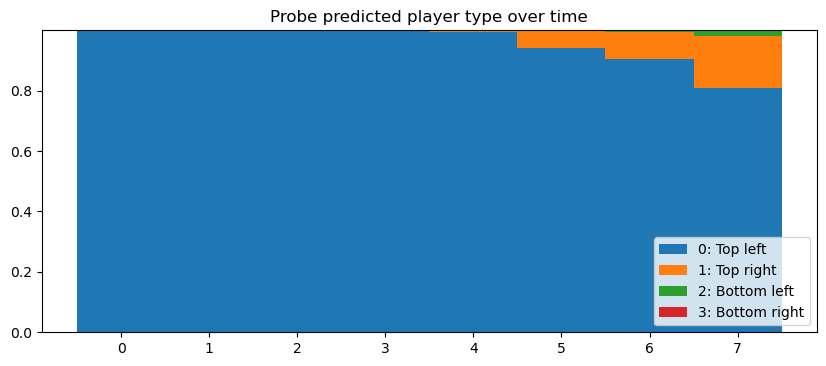

In [47]:
layer_preds = []
for layer in full_layer_range:
    logits = get_playertype_logits(models, device, all_probes, completion, layer, softmax=True).flatten()
    layer_preds.append(logits)
    # print(layer, logits)
fig = probe_pred_stack_chart(layer_preds)

In [54]:
game_full_len = len(othello[0])
layer_preds_over_time = []
for i in range(1, game_full_len):
    completion = othello[0][:i]
    layer_preds = []
    for layer in full_layer_range:
        logits = get_playertype_logits(models, device, all_probes, completion, layer, softmax=True).flatten()
        layer_preds.append(logits)
    layer_preds_over_time.append(layer_preds)

In [ ]:
from PIL import Image

heatmap_images = []

for layer_preds in layer_preds_over_time:
    
    fig = probe_pred_stack_chart(layer_preds)

    # Convert the heatmap plot to an image
    fig.canvas.draw()
    heatmap_image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
    heatmap_images.append(heatmap_image)

heatmap_images[0].save('heatmap_animation.gif', save_all=True, append_images=heatmap_images[1:], loop=0)